# Preprocessing Dataset

## Imports

In [10]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from tifffile import imwrite, imread

import sys
sys.path.append('code')
from eval_functions import _mask_to_boundary
sys.path.append('../')

## Preprocess dataset

MapAI uses images of 500x500 pixels. This input wont work on a U-Net networks as when we are Max-pooling the results will be: 500->250->125->62->... This 62 will later then be sampled up to 124 which will be a mismatch with 125. For the U-Net part of the thesis we will therefore scale up the training, validation and test images to 512x512.


In [11]:
# Defining sets that has to be rescaled
datasets = ['train', 'validation', 'task1_test', 'task2_test']

# Define image size
original_size = 500
new_size = 512

for dataset in tqdm(datasets):
    # Make directory for preprocessed dataset
    dataset_path = os.path.normpath('dataset/MapAI/preprocessed_' + dataset)
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    # Folder structure for data generator
    label = None
    if dataset == 'train':
        label = 'train'
    elif dataset == 'validation':
        label = 'val'
    else:
        label = ''

    # Make directory for preprocessed subsets
    mask_path = os.path.normpath('dataset/MapAI/preprocessed_' + dataset + '/mask/' + label)
    image_path = os.path.normpath('dataset/MapAI/preprocessed_' + dataset + '/image/' + label)
    rgblidar_path = os.path.normpath('dataset/MapAI/preprocessed_' + dataset + '/rgbLiDAR/' + label)
    edge_mask_path = os.path.normpath('dataset/MapAI/preprocessed_' + dataset + '/edge_mask/' + label)
    original_mask_path = os.path.normpath('dataset/MapAI/' + dataset + '/mask')
    original_image_path = os.path.normpath('dataset/MapAI/' + dataset + '/image')
    original_lidar_path = os.path.normpath('dataset/MapAI/' + dataset + '/lidar')

    if not os.path.exists(mask_path):
        os.makedirs(mask_path)
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    if not os.path.exists(rgblidar_path):
        os.makedirs(rgblidar_path)
    if not os.path.exists(edge_mask_path):
        os.makedirs(edge_mask_path)

    # Upscale images to 512x512
    with os.scandir(original_mask_path) as entries:
        for entry in entries:
            filename = entry.name.split(".")[0]

            mask_img = cv.imread(os.path.normpath(original_mask_path + '/' + entry.name), cv.IMREAD_GRAYSCALE)
            mask_img[mask_img == 255] = 1

            # Resize images
            # Mask
            resize_mask_img = cv.resize(mask_img, (new_size, new_size), interpolation = cv.INTER_AREA)
            cv.imwrite(os.path.normpath(mask_path + '/' + entry.name), resize_mask_img)

            # Edge mask
            edge_mask = _mask_to_boundary(resize_mask_img)
            edge_mask[edge_mask == 255] = 1
            cv.imwrite(os.path.normpath(edge_mask_path + '/' + entry.name), edge_mask)

            # Image
            img = cv.imread(os.path.normpath(original_image_path + '/' + entry.name), cv.IMREAD_COLOR)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            resize_img = cv.resize(img, (new_size, new_size), interpolation = cv.INTER_AREA)
            resize_img = cv.cvtColor(resize_img, cv.COLOR_BGR2RGB)
            cv.imwrite(os.path.normpath(image_path + '/' + entry.name), resize_img)

            # LiDAR RGB -> Concat aerial image and lidar data
            if dataset != 'task1_test':
                lidar_data = np.load(os.path.normpath(original_lidar_path + '/' + filename + '.npy'))
                resize_lidar = cv.resize(lidar_data, (new_size, new_size), interpolation = cv.INTER_AREA)
                resize_lidar = np.expand_dims(resize_lidar, axis=-1)
                rgb_lidar = np.concatenate((resize_img, resize_lidar), axis=-1)
                imwrite(rgblidar_path + '/' + filename + '.tif', rgb_lidar.astype(np.uint8))


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [11:13<00:00, 168.40s/it]


In [14]:
# Displaying images before and after resizing
def show_images(set_name, data_name):
    path_new = os.path.normpath('dataset/MapAI/preprocessed_' + set_name)
    
    label = None
    if set_name == 'train':
        label = 'train'
    elif set_name == 'validation':
        label = 'val'
    else:
        label = ''
    
    # Define plot
    plt.figure(figsize=(20,20))
    
    # Get rgb lidar image
    rgb_lidar = imread(os.path.normpath(path_new + '/rgbLiDAR/train/' + data_name + '.tif'))
    
    # Find and display aerial image
    plt.subplot(141)
    plt.title('Aerial Image')
    aerial_img = cv.cvtColor(rgb_lidar[:, :, 0:3], cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    
    # Find and display mask image
    plt.subplot(142)
    plt.title('Mask Image')
    mask_img = cv.imread(os.path.normpath(path_new + '/mask/train/'  + data_name + '.PNG'))
    plt.imshow(mask_img * 255, cmap='gray')
    
    # Find and display LiDAR image
    plt.subplot(143)
    plt.title('LiDAR Image')
    plt.imshow(rgb_lidar[:, :, 3], cmap='gray')
    
    # Find and display edge mask image
    plt.subplot(144)
    plt.title('Edge Mask Image')
    edge_mask_img = cv.imread(os.path.normpath(path_new + '/edge_mask/train/'  + data_name + '.PNG'))
    plt.imshow(edge_mask_img * 255, cmap='gray')

    
    plt.show()

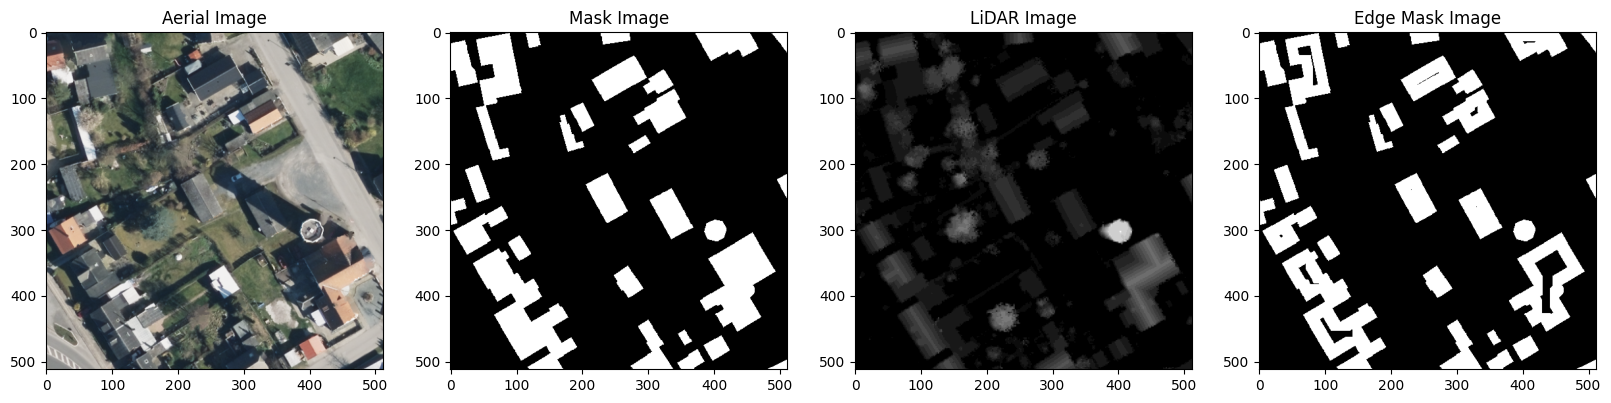

In [15]:
show_images('train', '6051_689_1')